In [1]:
#!usr/bin/env python

# Right-Invariant Extended Kalman filter class for 2D Localization, SE(2).

import numpy as np
from scipy.linalg import block_diag, expm


class Right_IEKF:

    def __init__(self, system):
        # Right_IEKF Construct an instance of this class
        #
        # Input:
        #   system:     system and noise models
        self.A = system['A']  # error dynamics matrix
        self.f = system['f']  # process model
        self.H = system['H']  # measurement error matrix
        self.Q = system['Q']  # input noise covariance
        self.N = system['N']  # measurement noise covariance
        self.X = np.eye(3)  # state vector
        self.P = 0.1 * np.eye(3)  # state covariance

    def Ad(self, X):
        # Adjoint
        AdX = np.hstack((X[0:2, 0:2], np.array([[X[1, 2]], [-X[0, 2]]])))
        AdX = np.vstack((AdX, np.array([0, 0, 1])))
        return AdX

    def wedge(self, x):
        # wedge operation for se(2) to put an R^3 vector to the Lie algebra basis
        G1 = np.array([[0, -1, 0],
                       [1, 0, 0],
                       [0, 0, 0]])  # omega
        G2 = np.array([[0, 0, 1],
                       [0, 0, 0],
                       [0, 0, 0]])  # v_1
        G3 = np.array([[0, 0, 0],
                       [0, 0, 1],
                       [0, 0, 0]])  # v_2
        xhat = G1 * x[0] + G2 * x[1] + G3 * x[2]
        return xhat

    def prediction(self, u):
        # EKF propagation (prediction) step
        self.P = np.dot(np.dot(self.A, self.P), self.A.T) + np.dot(np.dot(self.Ad(self.X), self.Q), self.Ad(self.X).T)
        self.X = self.f(self.X, u)

    def correction(self, Y1, b1, Y2, b2):
        # RI-EKF correction Step
        H = np.vstack((self.H(b1-1), self.H(b2-1)))  # stack H
        h1 = H[0:2, :]
        h2 = H[3:5, :]
        H = np.vstack((h1, h2))  # 4 x 3 matrix, remove zero rows
        N = np.dot(np.dot(self.X, block_diag(self.N, 0)), self.X.T)
        N = block_diag(N[0:2, 0:2], N[0:2, 0:2])  # 4 x 4 block-diagonal matrix
        # filter gain
        S = np.dot(np.dot(H, self.P), H.T) + N
        L = np.dot(np.dot(self.P, H.T), np.linalg.inv(S))

        # Update state
        nu = np.dot(block_diag(self.X, self.X), np.vstack((Y1, Y2))) - np.vstack((b1.reshape(-1, 1), b2.reshape(-1, 1)))
        nu = np.hstack((nu[0:2, 0], nu[3:5, 0]))
        delta = self.wedge(np.dot(L, nu))  # innovation in the spatial frame
        self.X = np.dot(expm(delta), self.X)

        # Update Covariance
        I = np.eye(np.shape(self.P)[0])
        temp = I - np.dot(L, H)
        self.P = np.dot(np.dot(temp, self.P), temp.T) + np.dot(np.dot(L, N), L.T)

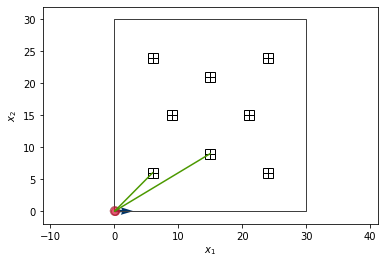

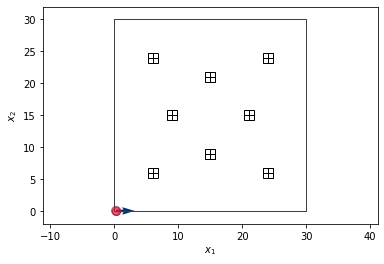

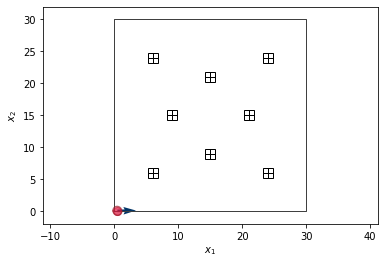

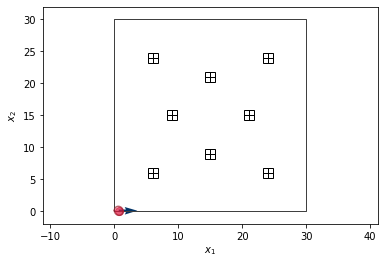

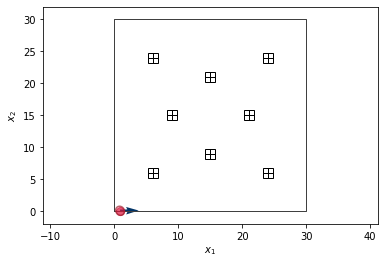

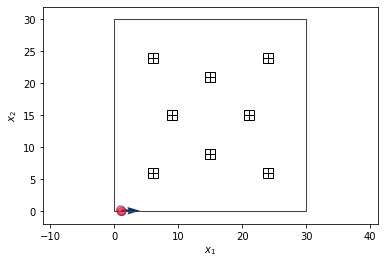

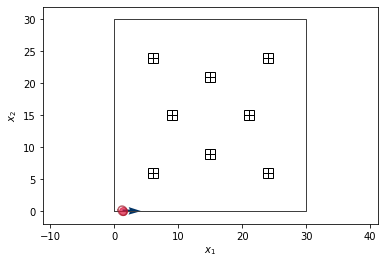

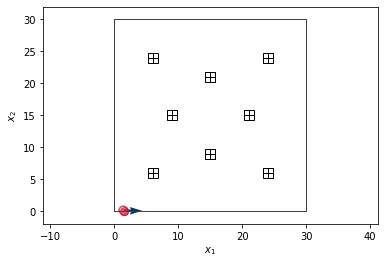

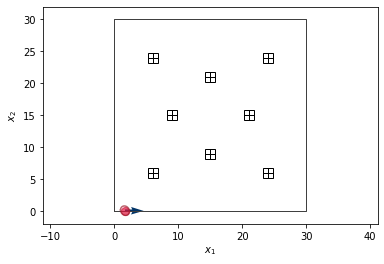

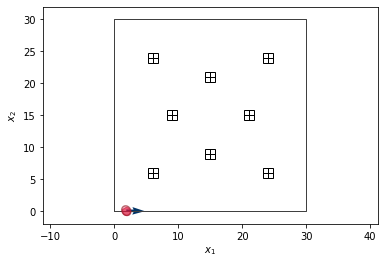

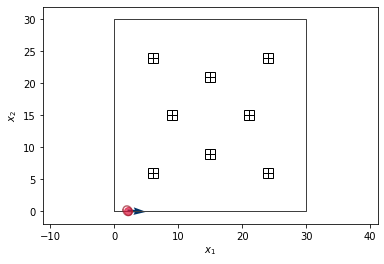

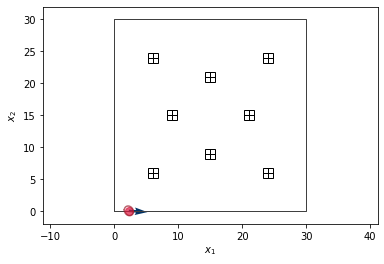

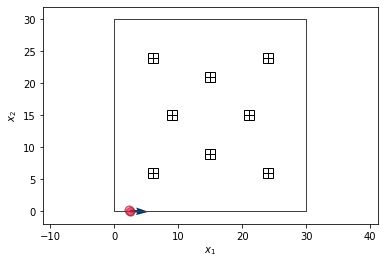

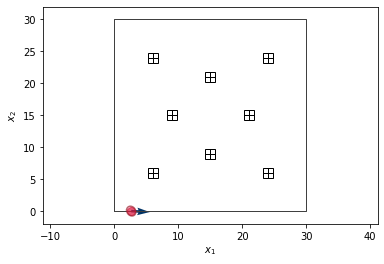

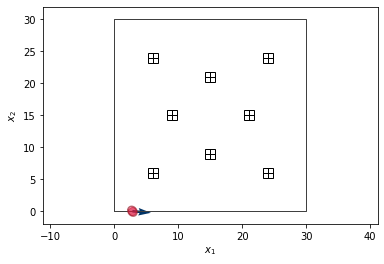

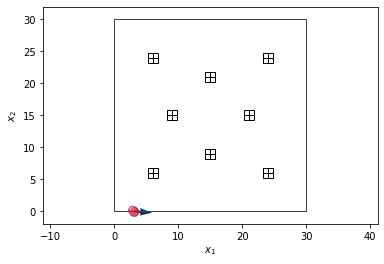

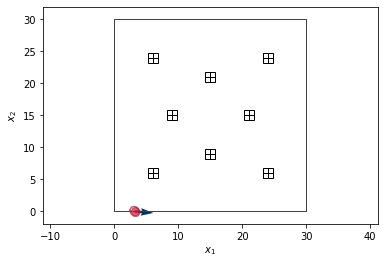

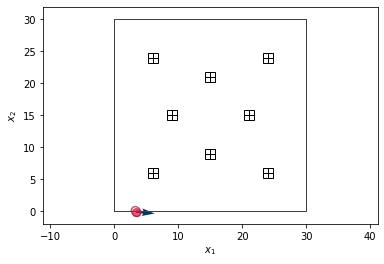

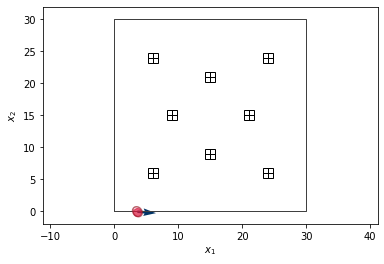

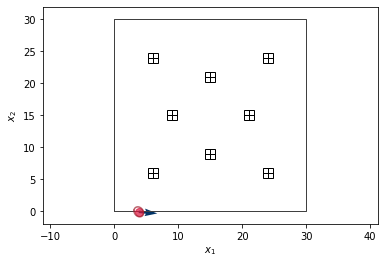

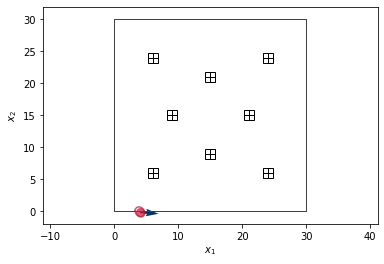

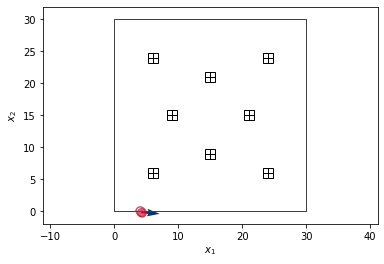

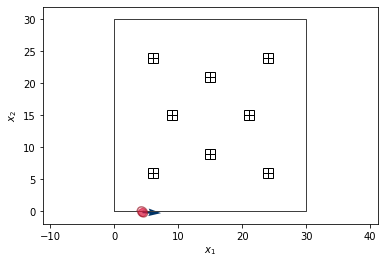

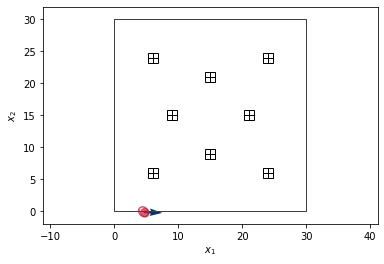

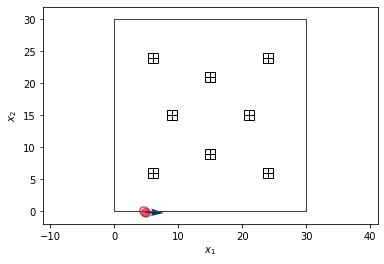

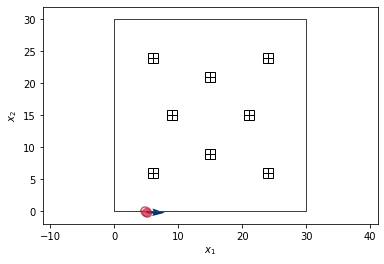

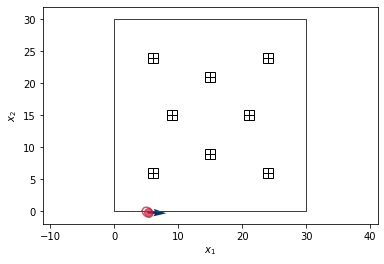

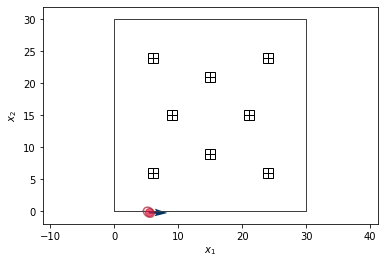

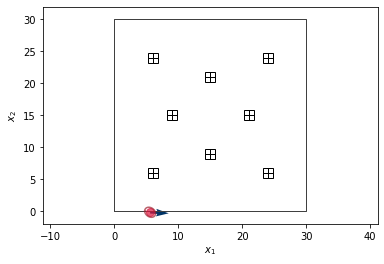

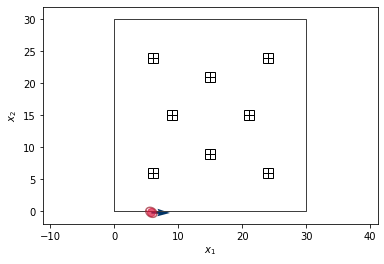

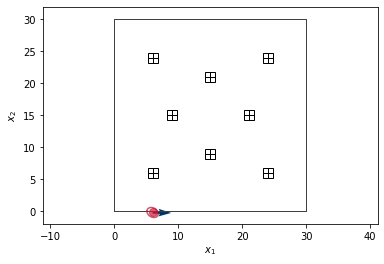

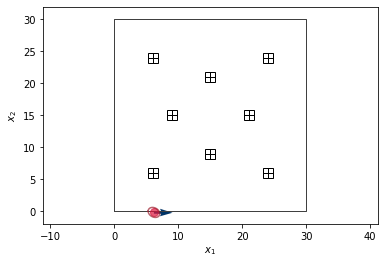

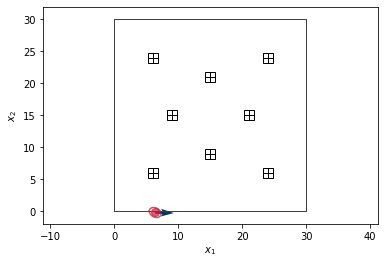

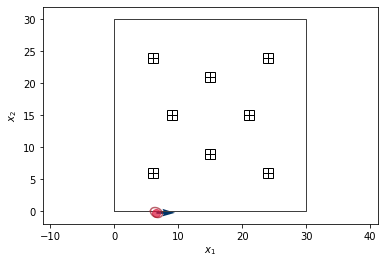

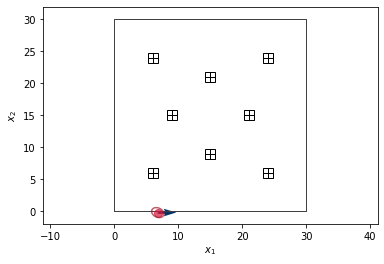

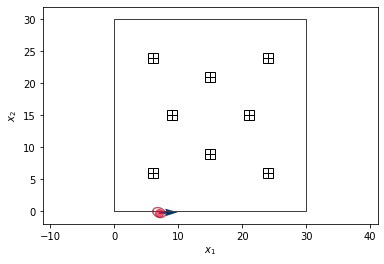

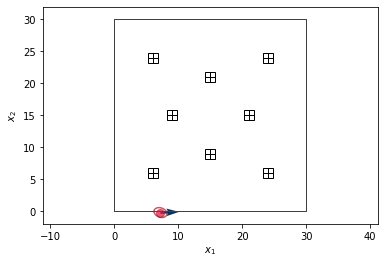

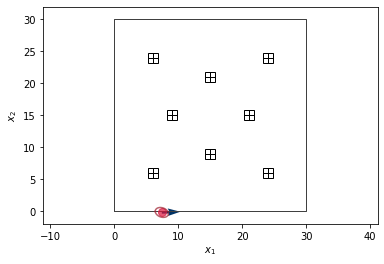

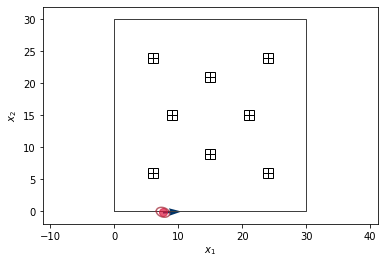

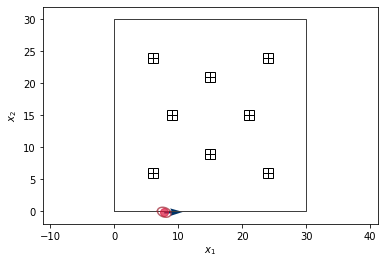

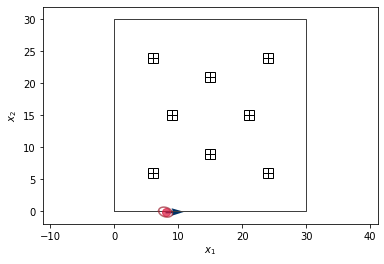

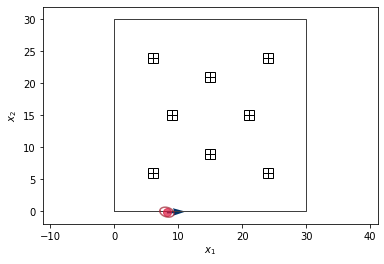

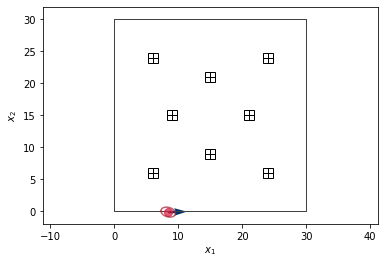

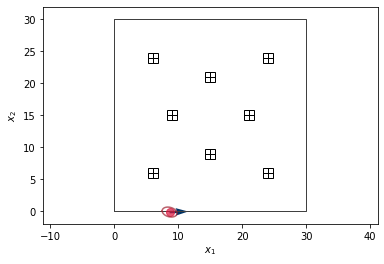

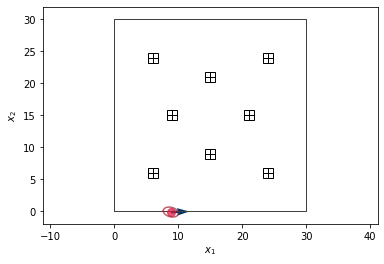

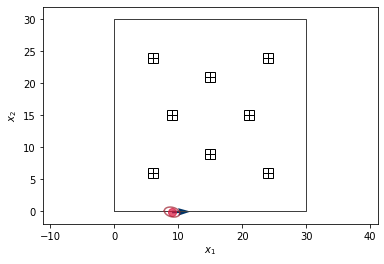

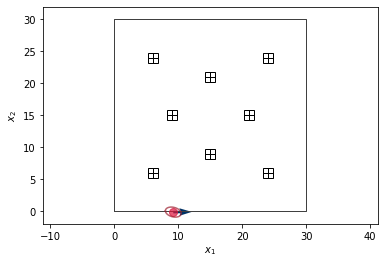

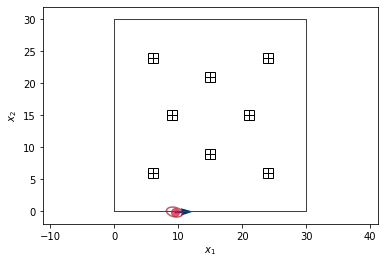

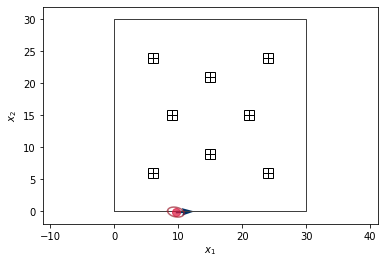

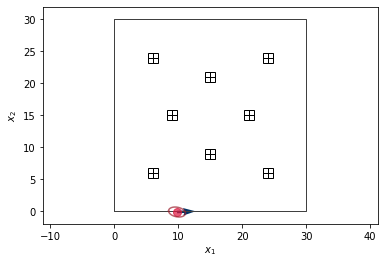

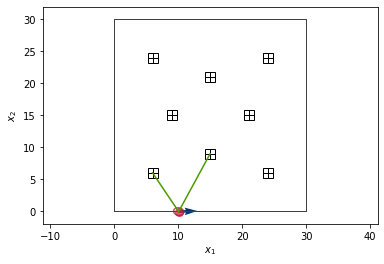

KeyboardInterrupt: 

In [3]:
#!usr/bin/env python

#
# Right-Invariant EKF localization on SE(2). The process model is simply
# X_k+1 = X_k * exp(u_k + w_k) where X_k is in SE(2), u_k is the twist in
# se(2), and w_k is N(0, Q_k) and defined in the LIe algebra se(2). The
# measurements are noisy 2D coordinates of the landmarks in Cartesian plane.
# We use expm and logm as numerical Lie exp and log map. Both maps have
# closed-form formulas as well.

import numpy as np
from scipy.linalg import logm, expm
from scipy.spatial import KDTree
from matplotlib import pyplot as plt
import matplotlib.animation as ani
#from riekf import Right_IEKF
import cv2


def sort_idxlist(idx, map, pt):
    # sort the KDTree Neighbours by distance
    map_idx = map[idx, :]
    dis_map = np.sqrt(np.sum((map_idx-pt)*(map_idx-pt), 1))
    dis_map_idx = np.concatenate((dis_map.reshape(-1, 1), np.array(idx).reshape(-1, 1)), 1)
    sorted_dis = dis_map_idx[np.lexsort(dis_map_idx[:, ::-1].T)]
    return sorted_dis[:, 1].astype(int)


def motion_model(x, u):
    return np.dot(x, expm(u))


def measurement_error_matrix(m):
    # measurement error matrix
    H = np.array([[m[1], -1, 0],
                  [-m[0], 0, -1],
                  [0, 0, 0]])
    return H


def posemat(x, y, h):
    # construct a SE(2) matrix element
    H = np.array([[np.cos(h), -np.sin(h), x],
                  [np.sin(h), np.cos(h), y],
                  [0, 0, 1]])
    return H

def poseinv(H):
    # compute the inverse of a SE(2) matrix element
    Hinv = np.eye(3)
    Hinv[:2,:2] = H[:2,:2].T
    Hinv[:2,2] = -H[:2,:2].T.dot(H[0:2,2])
    return Hinv


def confidence_ellipse(X, L):
    # create confidence ellipse
    # se(2) Lie algebra basis twist = vec(omega, v1, v2)
    G1 = np.array([[0, -1, 0],
                   [1, 0, 0],
                   [0, 0, 0]])
    G2 = np.array([[0, 0, 1],
                   [0, 0, 0],
                   [0, 0, 0]])
    G3 = np.array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 0, 0]])

    # first create points from a unit circle + angle (third dimension of so(3))
    phi = np.arange(-np.pi, np.pi+0.01, 0.01)
    circle = np.array([np.zeros([len(phi), 1]), np.cos(phi).reshape(-1, 1), np.sin(phi).reshape(-1, 1)]).reshape(3, -1)
    # Chi-squared 2-DOF 95% confidence (0.05): 7.815
    scale = np.sqrt(7.815)
    # main loop; iterate over the control inputs and move the robot
    ELLIPSE = np.zeros([circle.shape[1], 2])  # covariance ellipse on manifold (nonlinear)
    for j in range(circle.shape[1]):
        # sample covariance on SE(2)
        ell_se2_vec = scale * np.dot(L, circle[:, j])
        # retract and left-translate the ellipse on Lie algebra to SE(2) using Lie exp map
        temp = np.dot(X, expm(G1 * ell_se2_vec[0] + G2 * ell_se2_vec[1] + G3 * ell_se2_vec[2]))
        ELLIPSE[j, :] = np.array([temp[0, 2], temp[1, 2]])
    return ELLIPSE


if __name__ == "__main__":

    # generate a path
    l = 30  # scale the simulation
    dt = 0.2
    gt = {}
    n = len(np.arange(0, l+dt, dt))
    gt['x'] = np.hstack((np.arange(0, l+dt, dt).reshape(1, -1), l * np.ones([1, n]).reshape(1, -1),
                         np.arange(l, 0-dt, -dt).reshape(1, -1), np.zeros([1, n]).reshape(1, -1)))
    gt['y'] = np.hstack((np.zeros([1, n]).reshape(1, -1), np.arange(0, l+dt, dt).reshape(1, -1),
                         l * np.ones([1, n]).reshape(1, -1), np.arange(l, 0-dt, -dt).reshape(1, -1)))

    # find the headings tangent to the path
    gt['h'] = [0]
    for i in range(1, gt['x'].shape[1]):
        gt['h'].append(np.arctan2(gt['y'][0, i] - gt['y'][0, i-1], gt['x'][0, i] - gt['x'][0, i - 1]))

    # ground truth poses
    H = [np.eye(3)]
    for i in range(1, gt['x'].shape[1]):
        H.append(posemat(gt['x'][0, i], gt['y'][0, i], gt['h'][i]))

    # generate noise-free twist control inputs (velocity commands) in the Lie algebra
    u = [np.zeros([3, 3])]
    for i in range(1, gt['x'].shape[1]):
        logm_temp = logm(np.dot(poseinv(H[i-1]),H[i]))
        u.append(logm_temp)

    # construct noise free motion trajectory (sanity check for the generated inputs)
    path = {}
    path['T'] = H[0]
    path['x'] = [0]
    path['y'] = [0]
    for i in range(1, len(u)):
        path['T'] = np.dot(path['T'], expm(u[i]))
        path['x'].append(path['T'][0, 2])
        path['y'].append(path['T'][1, 2])

    # map of landmarks
    landmarks = np.dot(l, np.array([[0.2, 0.2],
                                    [0.5, 0.3],
                                    [0.8, 0.2],
                                    [0.7, 0.5],
                                    [0.8, 0.8],
                                    [0.5, 0.7],
                                    [0.2, 0.8],
                                    [0.3, 0.5]]))
    Map = KDTree(landmarks)

    # build a system
    sys = {}
    # motion model noise covariance
    sys['Q'] = np.diag(np.power([0.015, 0.01, 0.01], 2))
    sys['A'] = np.eye(3)
    sys['f'] = motion_model
    sys['H'] = measurement_error_matrix
    sys['N'] = np.diag(np.power([0.5, 0.5], 2))

    # se(2) Lie algebra basis twist = vec(omega, v1, v2)
    G1 = np.array([[0, -1, 0],
                   [1, 0, 0],
                   [0, 0, 0]])
    G2 = np.array([[0, 0, 1],
                   [0, 0, 0],
                   [0, 0, 0]])
    G3 = np.array([[0, 0, 0],
                   [0, 0, 1],
                   [0, 0, 0]])

    # now make the twist noisy! In practice, the velocity readings are not perfect.
    # Cholesky factor of covariance for sampling
    LQ = np.linalg.cholesky(sys['Q'])
    for i in range(len(u)):
        noise = np.dot(LQ, np.random.randn(3, 1))
        N = G1 * noise[0] + G2 * noise[1] + G3 * noise[2]
        u[i] = u[i] + N

    # incremental visualization
    green = np.array([0.2980, 0.6, 0])
    crimson = np.array([220, 20, 60]) / 255
    darkblue = np.array([0, 0.2, 0.4])
    Darkgrey = np.array([0.25, 0.25, 0.25])
    VermillionRed = np.array([156, 31, 46]) / 255
    DupontGray = np.array([144, 131, 118]) / 255

    fig = plt.figure()
    plt.plot(path['x'], path['y'], '-', color=Darkgrey, linewidth=1)
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')
    plt.axis('equal')
    plt.xlim([-2, 32])
    plt.ylim([-2, 32])

    # plot map
    plt.plot(landmarks[:, 0], landmarks[:, 1], '+k', markersize=10, fillstyle='none')
    plt.plot(landmarks[:, 0], landmarks[:, 1], 'sk', markersize=10, fillstyle='none')

    # Cholesky factor of measurement noise covariance for sampling
    LN = np.linalg.cholesky(sys['N'])

    iekf_filter = Right_IEKF(sys)  # create an RI-EKF object

    # plot initial mean
    plt.plot(iekf_filter.X[0, 2], iekf_filter.X[1, 2], 'o', color=crimson, alpha=0.7, markersize=8)
    plt.quiver(iekf_filter.X[0, 2], iekf_filter.X[1, 2], 10 * iekf_filter.X[0, 0], 10 * iekf_filter.X[1, 0], color=darkblue)
    ELLIPSE = confidence_ellipse(iekf_filter.X, np.linalg.cholesky(iekf_filter.P))
    plt.plot(ELLIPSE[:, 0], ELLIPSE[:, 1], color=VermillionRed, alpha=0.7, linewidth=1.5)
    plt.plot([iekf_filter.X[0, 2], landmarks[0, 0]], [iekf_filter.X[1, 2], landmarks[0, 1]], '-', color=green, linewidth=1.5)

    # video recorder object




    skip = 50
    for i in range(len(u)):
        # predict next pose using given twist
        iekf_filter.prediction(u[i])
        m_id = []
        if not np.mod(i, skip):
            # get a landmark measurement using current true position of the robot
            m_dist, m_id = Map.query([gt['x'][0, i], gt['y'][0, i]], k=2)
            b1 = np.hstack((landmarks[m_id[0], :], 1))
            Y1 = np.dot(np.linalg.inv(H[i]), b1).reshape(-1, 1) + np.vstack((np.dot(LN, np.random.randn(2, 1)), 0))
            b2 = np.hstack((landmarks[m_id[1], :], 1))
            Y2 = np.dot(np.linalg.inv(H[i]), b2).reshape(-1, 1) + np.vstack((np.dot(LN, np.random.randn(2, 1)), 0))
            # correction based on the measurements
            iekf_filter.correction(Y1, b1, Y2, b2)

        # update graphics
        plt.clf()
        plt.plot(path['x'], path['y'], '-', color=Darkgrey, linewidth=1)
        plt.xlabel(r'$x_1$')
        plt.ylabel(r'$x_2$')
        plt.axis('equal')
        plt.xlim([-2, 32])
        plt.ylim([-2, 32])

        # plot map
        plt.plot(landmarks[:, 0], landmarks[:, 1], '+k', markersize=10, fillstyle='none')
        plt.plot(landmarks[:, 0], landmarks[:, 1], 'sk', markersize=10, fillstyle='none')

        plt.plot(iekf_filter.X[0, 2], iekf_filter.X[1, 2], 'o', color=crimson, alpha=0.7, markersize=8)
        plt.quiver(iekf_filter.X[0, 2], iekf_filter.X[1, 2], 10 * iekf_filter.X[0, 0], 10 * iekf_filter.X[1, 0],
                  color=darkblue)
        ELLIPSE = confidence_ellipse(iekf_filter.X, np.linalg.cholesky(iekf_filter.P))
        plt.plot(ELLIPSE[:, 0], ELLIPSE[:, 1], color=VermillionRed, alpha=0.7, linewidth=1.5)
        if not np.mod(i, skip):
            for j in range(len(m_id)):
                #plt.savefig('./IMG/{}.png'.format(i))
                plt.plot([iekf_filter.X[0, 2], landmarks[m_id[j], 0]], [iekf_filter.X[1, 2], landmarks[m_id[j], 1]], '-', color=green, linewidth=1.5)
            plt.pause(0.01)
        else:
            #plt.savefig('./IMG/{}.png'.format(i))
            plt.pause(0.01)


    plt.show()